<!-- # Analyze GAM models results -->

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from matplotlib.gridspec import GridSpec



from collections import defaultdict
from tqdm import tqdm

# Custom models
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import GAMinferenceModels_V2 as gam_models

<!-- # Load data -->

In [2]:
folder_name = "2022_2023_test_periods_highReg"
spline_version = '_5sALL_'

In [3]:
states_only = ['TEXAS', 'MASSACHUSETTS']
filter_states = False

In [4]:
full_model_results = {}

for csv_file in tqdm(os.listdir(f'../Results/GAM/{folder_name}/full{spline_version}/'), desc="Full Model Results"):
    if not csv_file.endswith('.csv'):
        continue
    state_name = csv_file.replace('.csv','').split('_')[-1]
    if filter_states and (state_name not in states_only):
        continue

    type_sim = csv_file.replace('.csv','').split('_')[-2]
    if type_sim != 'test':
        continue

    results_data = pd.read_csv(os.path.join(f'../Results/GAM/{folder_name}/full{spline_version}/', csv_file), parse_dates=['Datetime_UTC'])
    # results_data = results_data.loc[results_data['State'] == state_name].reset_index(drop=True)
    results_data['pAA'] = 1-results_data['pAD']-results_data['pAO']
    results_data['pDD'] = 1- results_data['pDA']
    results_data['pOO'] = 1- results_data['pOA']
    full_model_results[state_name] = results_data

Ar_model_results = {}
ar_model_general_results = pd.read_csv(f'../Results/GAM/{folder_name}/AR{spline_version}/GAM_Ar_results_test.csv', parse_dates=['Datetime_UTC'])
ar_model_general_results['pAA'] = 1-ar_model_general_results['pAD']-ar_model_general_results['pAO']
ar_model_general_results['pDD'] = 1- ar_model_general_results['pDA']
ar_model_general_results['pOO'] = 1- ar_model_general_results['pOA']

for state in full_model_results.keys():
    state_ar_results = ar_model_general_results[ar_model_general_results['State'] == state].reset_index(drop=True)
    Ar_model_results[state] = state_ar_results

As_model_results = {}
for csv_file in tqdm(os.listdir(f'../Results/GAM/{folder_name}/As{spline_version}/'), desc="AS Model Results"):
    if not csv_file.endswith('.csv'):
        continue
    state_name = csv_file.replace('.csv','').split('_')[-1]
    if filter_states and (state_name not in states_only):
        continue
    type_sim = csv_file.replace('.csv','').split('_')[-2]
    if type_sim != 'test':
        continue
    if state_name not in full_model_results:
        continue

    results_data = pd.read_csv(os.path.join(f'../Results/GAM/{folder_name}/As{spline_version}/', csv_file), parse_dates=['Datetime_UTC'])
    # results_data = results_data.loc[results_data['State'] == state_name].reset_index(drop=True)
    results_data['pAA'] = 1-results_data['pAD']-results_data['pAO']
    results_data['pDD'] = 1- results_data['pDA']
    results_data['pOO'] = 1- results_data['pOA']
    As_model_results[state_name] = results_data

LogisticReg_model_results = {}

for csv_file in tqdm(os.listdir(f'../Results/GAM/{folder_name}/LogisticReg/'), desc="Logistic Regression Model Results"):
    if not csv_file.endswith('.csv'):
        continue
    state_name = csv_file.replace('.csv','').split('_')[-1]
    if filter_states and (state_name not in states_only):
        continue
    type_sim = csv_file.replace('.csv','').split('_')[-2]
    if type_sim != 'test':
        continue
    if state_name not in full_model_results:
        continue

    results_data = pd.read_csv(os.path.join(f'../Results/GAM/{folder_name}/LogisticReg/', csv_file), parse_dates=['Datetime_UTC'])
    # results_data = results_data.loc[results_data['State'] == state_name].reset_index(drop=True)
    results_data['pAA'] = 1-results_data['pAD']-results_data['pAO']
    results_data['pDD'] = 1- results_data['pDA']
    results_data['pOO'] = 1- results_data['pOA']
    LogisticReg_model_results[state_name] = results_data


naive_model_results = {}
for csv_file in tqdm(os.listdir(f'../Results/GAM/{folder_name}/Naive_model/'), desc="Naive Model Results"):
    if not csv_file.endswith('.csv'):
        continue
    state_name = csv_file.replace('.csv','').split('_')[-1]
    if filter_states and (state_name not in states_only):
        continue
    if state_name not in full_model_results:
        continue
    results_data = pd.read_csv(os.path.join(f'../Results/GAM/{folder_name}/Naive_model/', csv_file), parse_dates=['Datetime_UTC'])
    # results_data = results_data.loc[results_data['State'] == state_name].reset_index(drop=True)

    full_res = full_model_results[state_name]
    assert len(set(full_res['Datetime_UTC']).difference(set(results_data['Datetime_UTC'])))==0, "Datetime_UTC do not match between full model and naive model results"
    results_data = results_data.merge(full_res[['Datetime_UTC','Stress']], on='Datetime_UTC', how='left')
    results_data['pAA'] = 1-results_data['pAD']-results_data['pAO']
    results_data['pDD'] = 1- results_data['pDA']
    results_data['pOO'] = 1- results_data['pOA']
    naive_model_results[state_name] = results_data

Naive Model Results: 100%|██████████| 47/47 [00:04<00:00, 11.43it/s]


In [5]:
models_evaluated = {
    'M': full_model_results,
    'AR': Ar_model_results,
    'AS': As_model_results,
    'LR': LogisticReg_model_results,
    'Naive': naive_model_results
}

<!-- # Analyze results -->

<!-- **3 Models to compare**:
- (M) : full
- (B) Benchmark (logistic regression)
- (As) : Ablation of $w_{stress}$
- (Ar) : Ablation of $w_{region}$

**Plots (for each start-end states):**
1. *Calibration Curve* (M only)
2. *Log likelihood*. x axis: stress bins (low, Medium, High, Very high) and different curves for different models
3. *Weighted calibration error*, stratified and normalized per probability bin. then display with x axis per stress bin and plot a curve per model
4. *Brier score*, same process as weighted calibration error -->

<!-- ### Compute stress bins

- **Low** : $\psi< p_{50}$
- **Medium** : $p_{50}\leq \psi< p_{90}$
- **High** : $p_{90}\leq \psi< p_{99}$
- **Very high** : $p_{99}\leq \psi$ -->

In [6]:
# exclude_states = ['VERMONT', 'WASHINGTON', 'DELAWARE', 'UTAH', 'ARIZONA', 'TENNESSEE']
exclude_states = []

In [7]:
w_stress = []
for state, state_data in full_model_results.items():
    state_data = state_data.drop_duplicates(subset=['Datetime_UTC']).reset_index(drop=True)
    w_stress.extend(state_data['Stress'].values)

w_stress = np.array(w_stress)

In [8]:
q = [0.5, 0.9, 0.99]
q_stress_bin_edges = np.quantile(w_stress, q)



test_data_stress_bins_per_state = defaultdict(lambda: defaultdict(dict))
for model_name, model_results in models_evaluated.items():
    for state, test_data in model_results.items():
        # test_data = gam_models.compute_fractions_by_time(test_data)
        data_with_freq = []
        test_data = test_data.copy()
        # test_data[['f0', 'f1', 'f2']] = None
        for initial_state in [0,1,2]:
            mask_initial_state = test_data['Initial_gen_state'] == initial_state
            test_data_state = test_data.loc[mask_initial_state].copy()
            l = len(test_data_state)
            fractions = gam_models.compute_fractions_by_time(test_data_state)
            test_data_state = test_data_state.merge(fractions[['Datetime_UTC', 'f0', 'f1', 'f2', 'Total_gen']], on='Datetime_UTC', how='left')
            data_with_freq.append(test_data_state)
            
        test_data = pd.concat(data_with_freq, ignore_index=True)
        # w_stress = test_data.drop_duplicates(subset=['Datetime_UTC']).reset_index(drop=True)['Stress'].values
        # if len(test_data)==0:
        #     continue
        # q_stress_bin_edges = np.quantile(w_stress, q)

        test_data_stress_bins_per_state[model_name][state] = {
            'Low': test_data.loc[test_data['Stress'] < q_stress_bin_edges[0]],
            'Medium': test_data.loc[(test_data['Stress'] >= q_stress_bin_edges[0]) & (test_data['Stress'] < q_stress_bin_edges[1])],
            'High': test_data.loc[(test_data['Stress'] >= q_stress_bin_edges[1]) & (test_data['Stress'] < q_stress_bin_edges[2])],
            'Very High': test_data.loc[test_data['Stress'] >= q_stress_bin_edges[2]],
        }

stress_bins_names = ['Low', 'Medium', 'High', 'Very High']

<!-- ## Calibration curves -->

In [9]:
importlib.reload(gam_models)

<module 'GAMinferenceModels_V2' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/GAMinferenceModels_V2.py'>

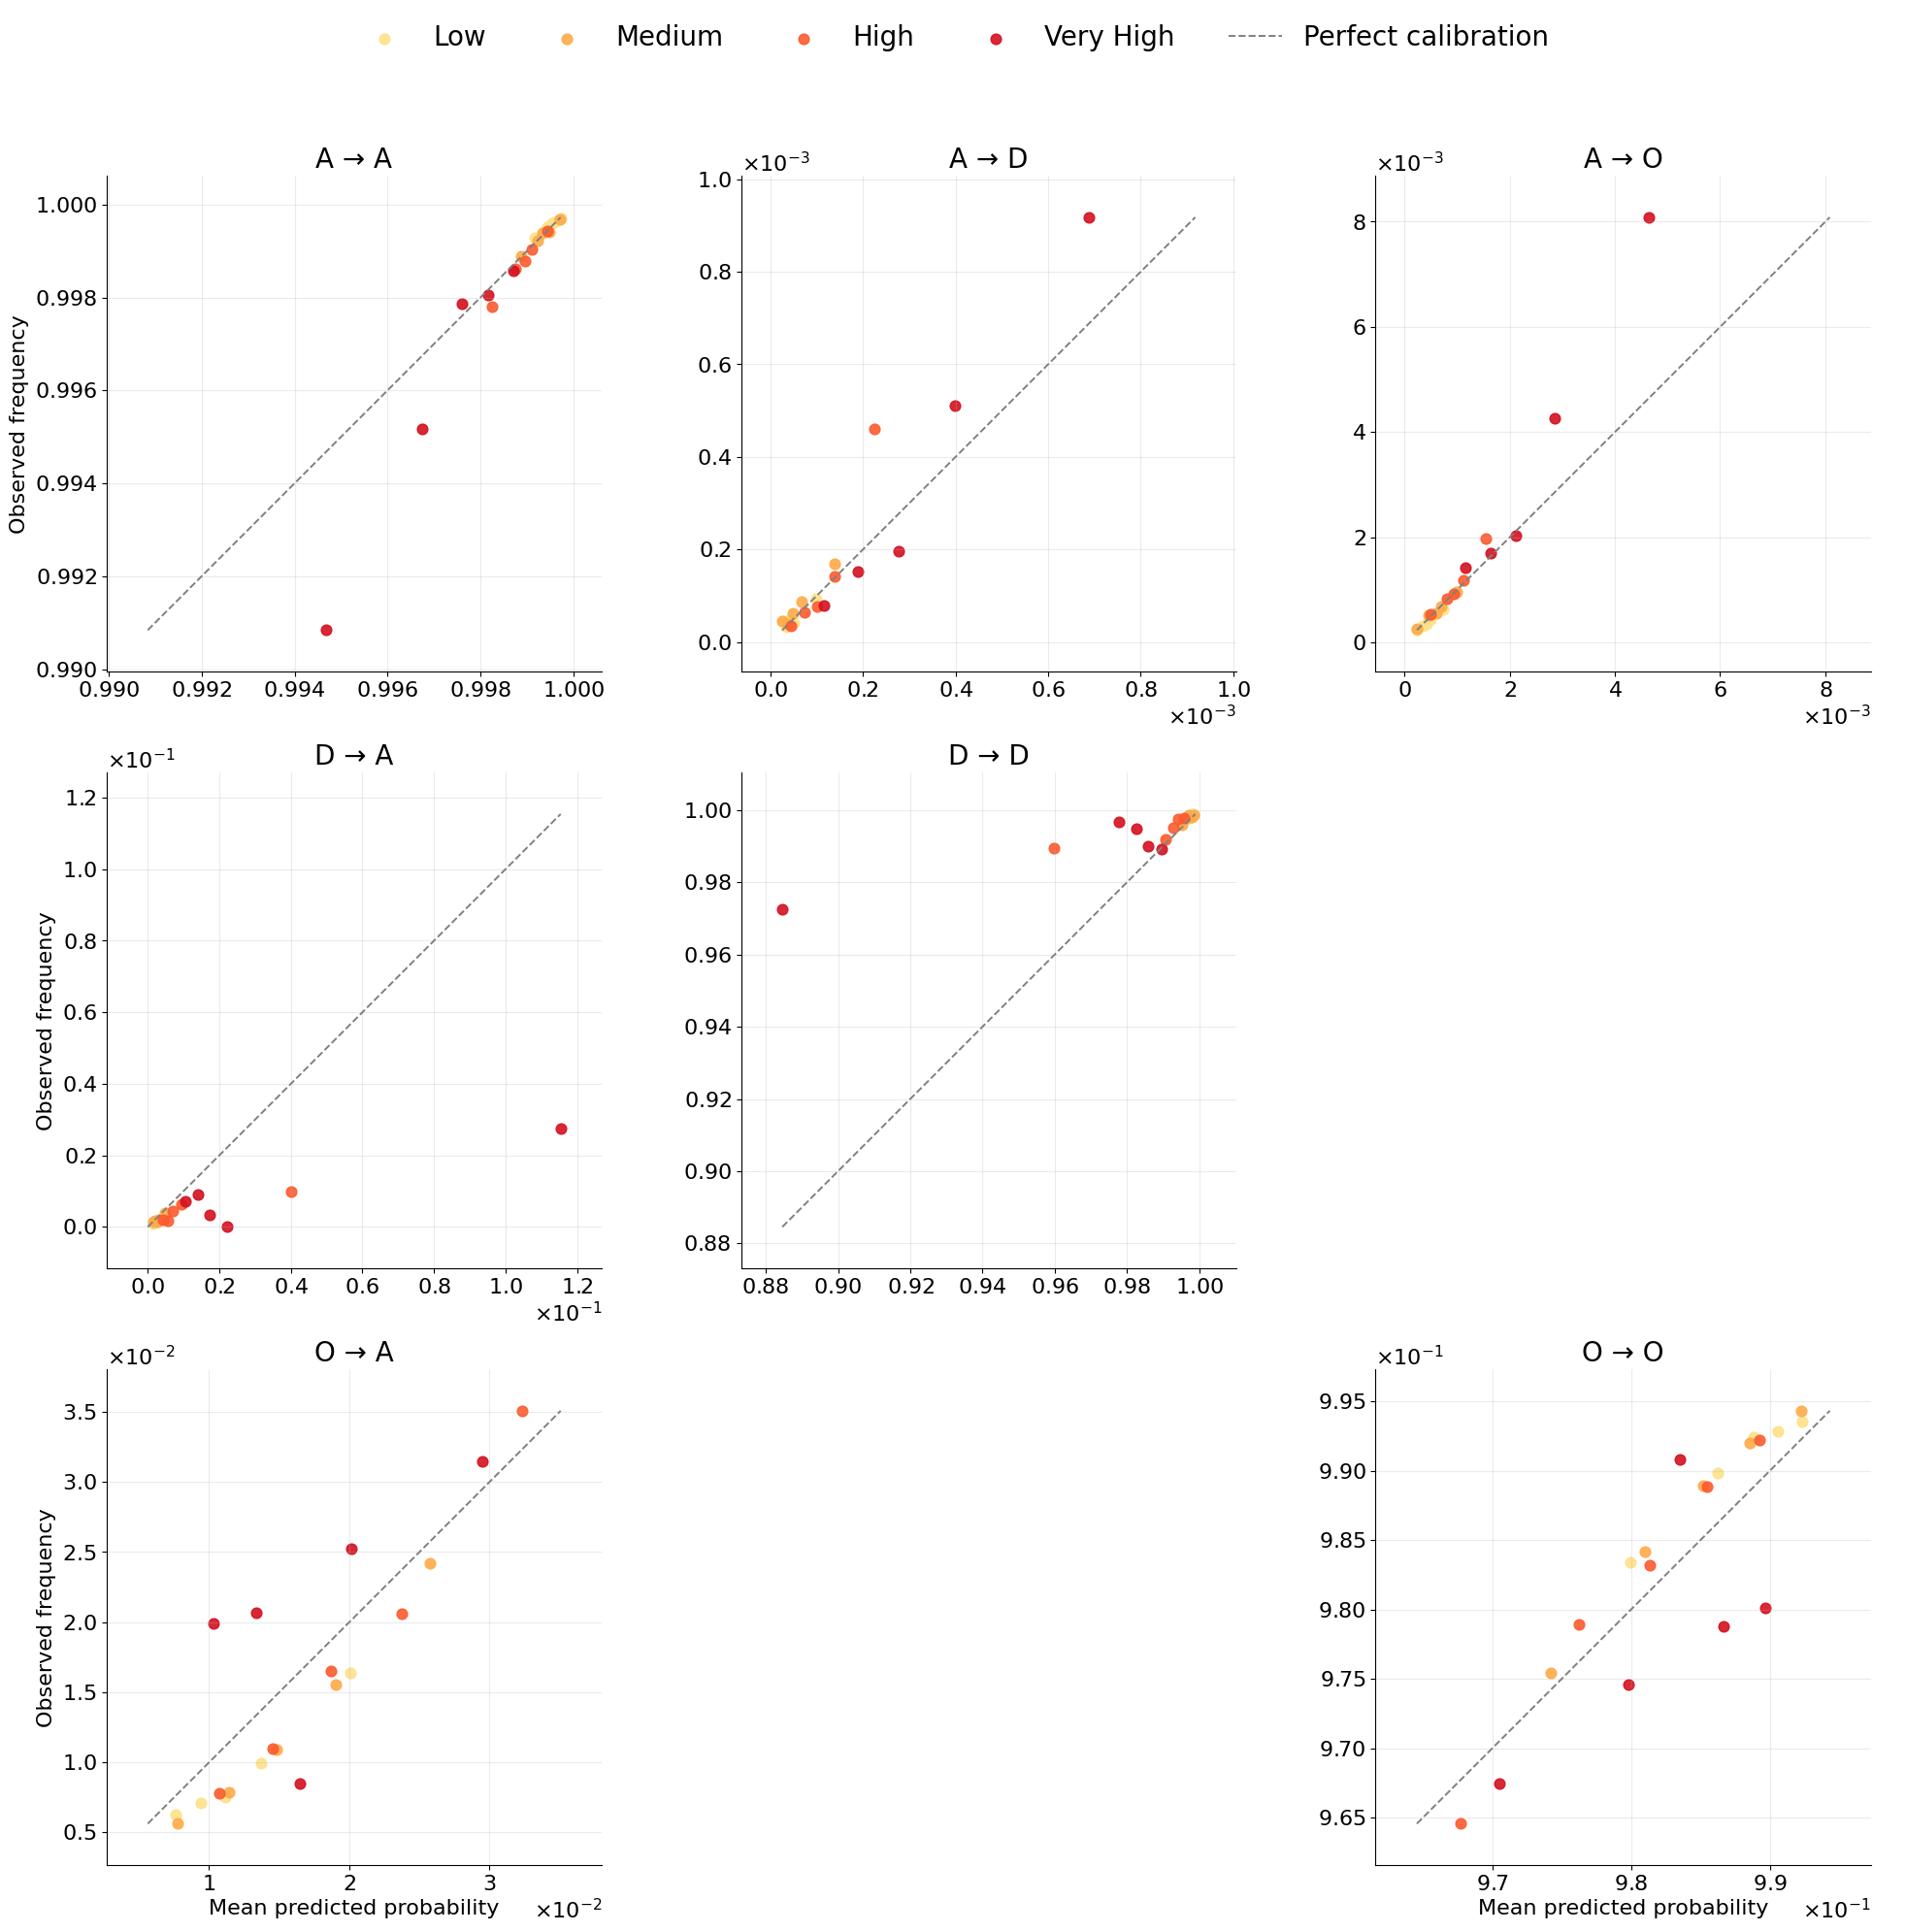

In [10]:
gam_models.plot_calibration_matrix(
    full_model_results={state:state_res for state,state_res in full_model_results.items() if state not in exclude_states},
    test_data_stress_bins_per_state={state:state_res for state,state_res in test_data_stress_bins_per_state['M'].items() if state not in exclude_states},
    n_bins=5,
)

<!-- ## Log likelihood -->

In [11]:
def NLL(p, w):
    d = - w*np.log(p)
    return np.sum(d)/np.sum(w)

In [12]:
state_idx2str = {0:'A', 1:'D', 2:'O'}
model_colors = {
    'M': 'tab:blue',
    'AR': 'tab:orange',
    'AS': 'tab:green',
    'LR': 'tab:red',
    'Naive': 'tab:gray',
}

<>:81: SyntaxWarning: invalid escape sequence '\D'
<>:81: SyntaxWarning: invalid escape sequence '\D'
/var/folders/6n/3dgg4xrs3xx6v3g6686g09nc0000gn/T/ipykernel_37967/4197508707.py:81: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel(f"$\Delta$ NLL vs Model {ref_model}")
/var/folders/6n/3dgg4xrs3xx6v3g6686g09nc0000gn/T/ipykernel_37967/1830203811.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(d)/np.sum(w)


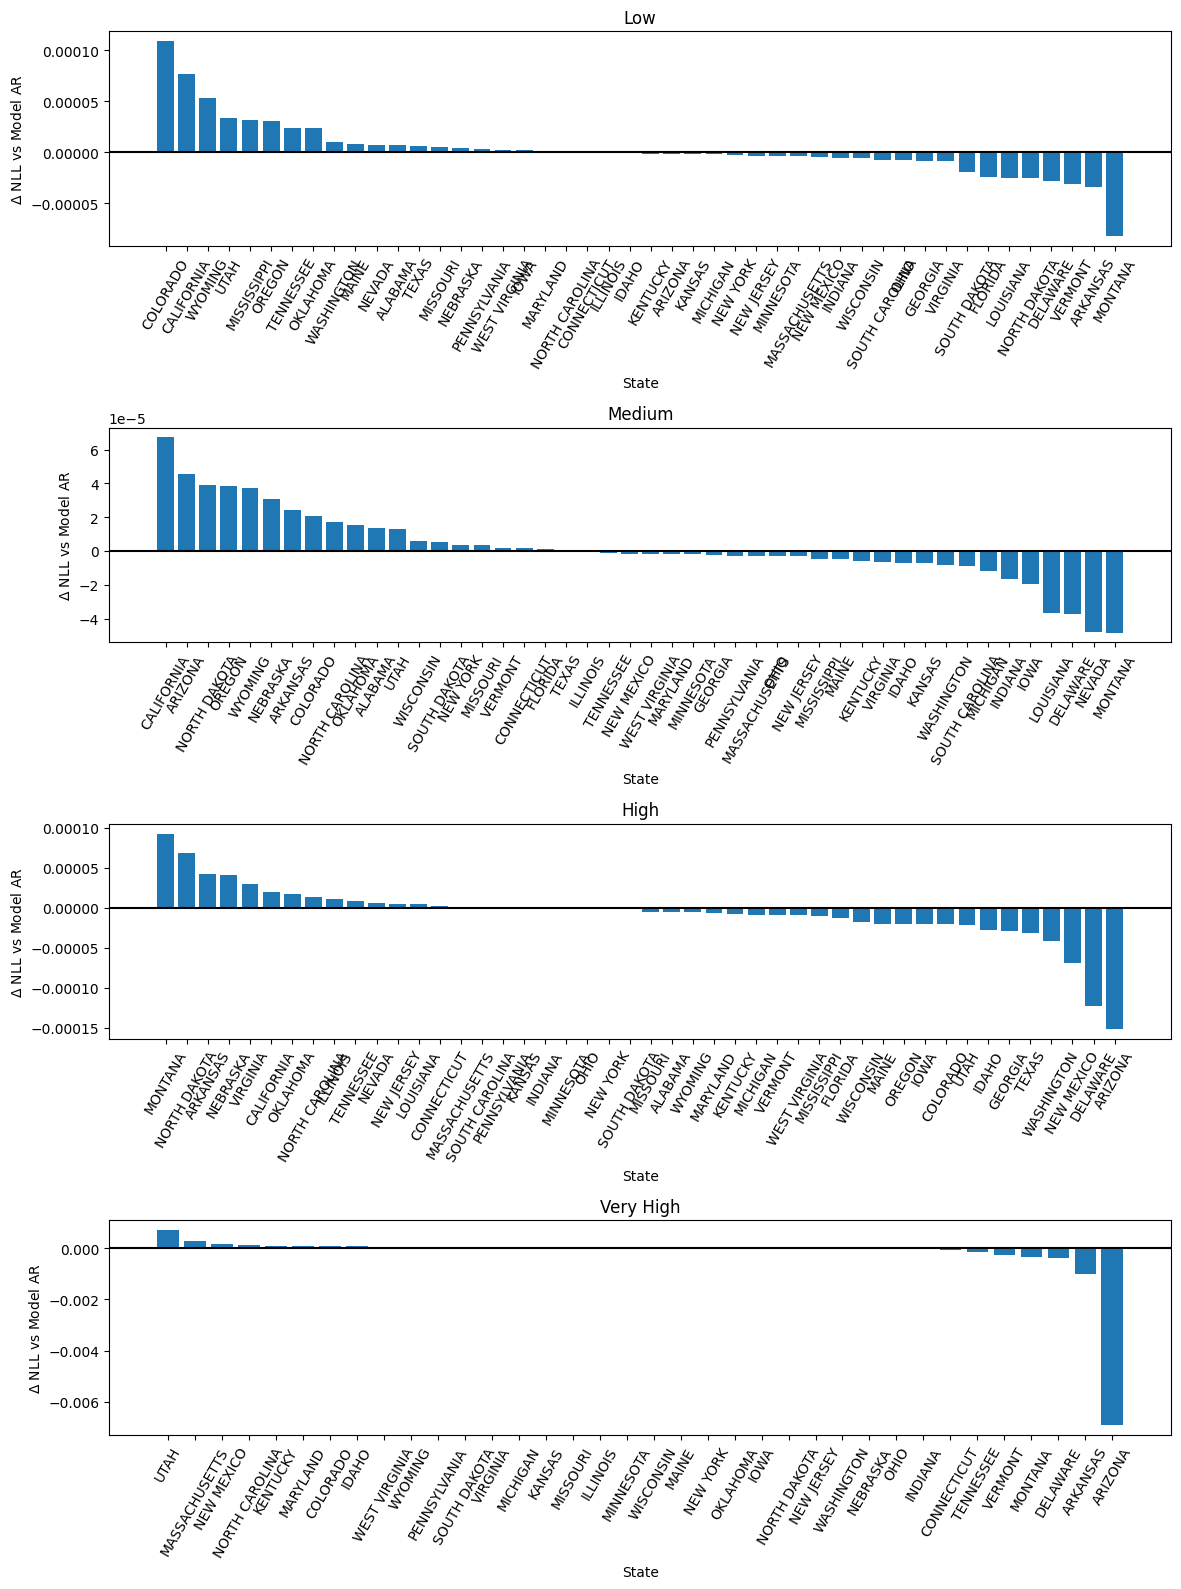

In [13]:
fig, axs = plt.subplots(4,1, figsize=(12,4*4))

nll_stress_state_ref = defaultdict(lambda: {})
ref_model = 'AR'
for state, test_data_per_bin in test_data_stress_bins_per_state[ref_model].items():    
    if state in exclude_states:
                continue
    for stress_level in stress_bins_names:
        p_pred = []
        n_gen = []
        test_data = test_data_per_bin[stress_level]
        for initial_state in [0,1,2]: 
        # for initial_state in [0,2]: 
            for final_state in [0,1,2]:
                if (initial_state, final_state) in [(1,2), (2,1)]:
                    continue
                mask = (test_data['Initial_gen_state'] == initial_state) & (test_data['Final_gen_state'] == final_state)
                p = test_data.loc[mask, f'p{state_idx2str[initial_state]}{state_idx2str[final_state]}'].to_numpy()
                w = test_data.loc[mask, 'Data_weight'].to_numpy()
                p_pred.extend(p)
                n_gen.extend(w)
        nll = NLL(np.array(p_pred), np.array(n_gen))
        nll_stress_state_ref[stress_level][state] = nll

nll_stress_state = defaultdict(lambda: {})
for state, test_data_per_bin in test_data_stress_bins_per_state['M'].items():
    if state in exclude_states:
                continue
    for stress_level in stress_bins_names:
        p_pred = []
        n_gen = []
        test_data = test_data_per_bin[stress_level]
        if test_data.empty:
            continue
        for initial_state in [0,1,2]: 
        # for initial_state in [0,2]: 
            for final_state in [0,1,2]:
                if (initial_state, final_state) in [(1,2), (2,1)]:
                    continue
                mask = (test_data['Initial_gen_state'] == initial_state) & (test_data['Final_gen_state'] == final_state)
                p = test_data.loc[mask, f'p{state_idx2str[initial_state]}{state_idx2str[final_state]}'].to_numpy()
                w = test_data.loc[mask, 'Data_weight'].to_numpy()
                p_pred.extend(p)
                n_gen.extend(w)
        nll = NLL(np.array(p_pred), np.array(n_gen))
        nll_stress_state[stress_level][state] = nll_stress_state_ref[stress_level][state]-nll

i=-1
for stress_level, stress_results in nll_stress_state.items():
    i+=1
    ax = axs[i]
    states = np.array(list(stress_results.keys()))
    nll = np.array(list(stress_results.values()))
    order = np.argsort(nll, kind="mergesort")[::-1]

    states, nll = states[order], nll[order]

    ax.bar(
        x=states,
        height=nll,
        # width=0.2,
        # label=model,
        # color=model_colors[model]
    )
    positions = np.arange(len(states))
    # max_val = max(np.abs(nlls_per_stress_bin)) if nlls_per_stress_bin else 0.0
    # y_offset = max_val * 0.01 if max_val != 0 else 1e-6
    # for xi, val in zip(positions, nlls_per_stress_bin):
    #     if val < 0:
    #         of = y_offset
    #     else:
    #         of = val+y_offset
    #     ax.text(xi,  of, f"{val:.5f}", ha='center', va='bottom', fontsize=9, rotation=90)
    
    # max_nll = max(nlls_per_stress_bin) if max(nlls_per_stress_bin) > max_nll else max_nll
    # min_nll = min(nlls_per_stress_bin) if min(nlls_per_stress_bin) < min_nll else min_nll
    ax.axhline(0, color='black')
    # ax.set_ylim(min_nll, max_nll*1.2)

    ax.set_xticks(np.arange(len(states)), labels=states, rotation=60)
    ax.set_ylabel(f"$\Delta$ NLL vs Model {ref_model}")
    ax.set_xlabel("State")
    ax.set_title(stress_level)
plt.tight_layout()
plt.show()


[0.00332823 0.00332801 0.00332535 0.00320555]


/var/folders/6n/3dgg4xrs3xx6v3g6686g09nc0000gn/T/ipykernel_37967/2218352652.py:261: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


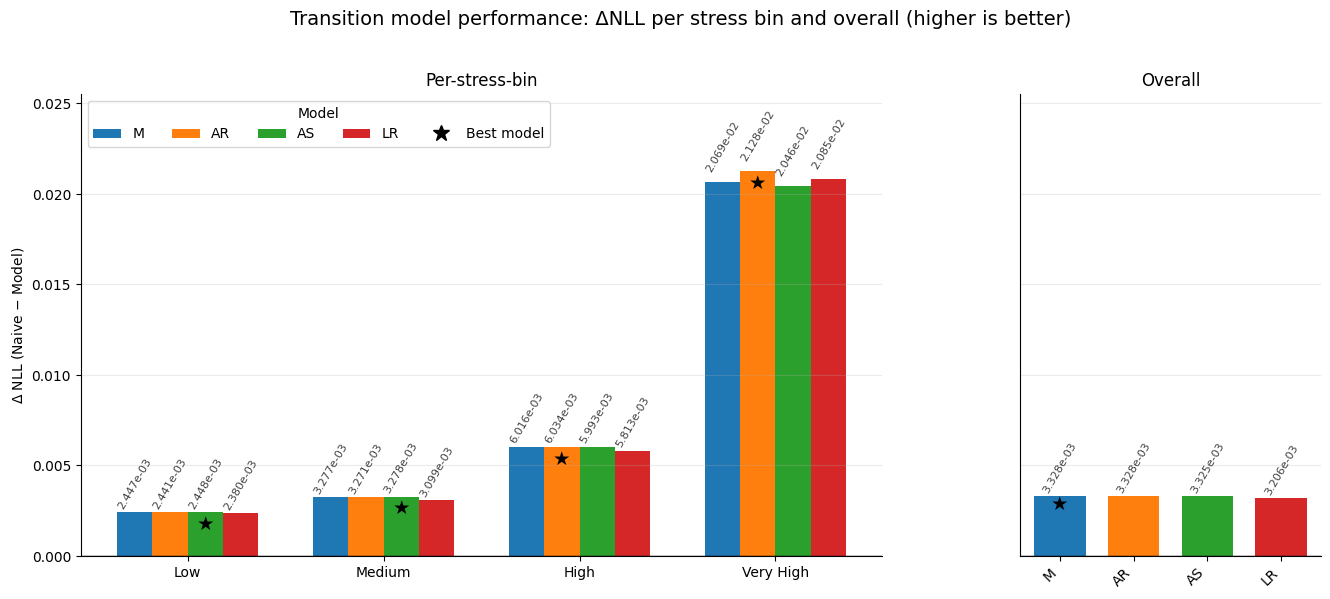

In [19]:
def plot_merged_delta_nll(
    test_data_stress_bins_per_state,
    models_evaluated,
    stress_bins_names,
    exclude_states,
    state_idx2str,
    model_colors,
    NLL,
    *,
    bar_width=0.18,
    figsize=(16, 6),
    print_label=True,
):
    # -----------------------------
    # Helpers
    # -----------------------------
    def _collect_p_w(df):
        """Collect p and w across all feasible transitions from df."""
        p_pred, w_all = [], []
        for initial_state in [0, 1, 2]:
            for final_state in [0, 1, 2]:
                if (initial_state, final_state) in [(1, 2), (2, 1)]:
                    continue
                mask = (df["Initial_gen_state"] == initial_state) & (df["Final_gen_state"] == final_state)
                p = df.loc[mask, f"p{state_idx2str[initial_state]}{state_idx2str[final_state]}"].to_numpy()
                w = df.loc[mask, "Data_weight"].to_numpy()
                if p.size:
                    p_pred.append(p)
                    w_all.append(w)
        if len(p_pred) == 0:
            return np.array([]), np.array([])
        return np.concatenate(p_pred), np.concatenate(w_all)
    
    def _annotate_bar(ax, x, y, *, fontsize=8):
        if not np.isfinite(y):
            return
        offset = 0.02 * np.sign(y)*y if y != 0 else 0.02
        ax.text(
            x,
            y + offset,
            f"{y:.3e}",
            ha="center",
            va="bottom" if y >= 0 else "top",
            fontsize=fontsize,
            color="0.25",
            rotation=60,
            clip_on=True,
        )

    # -----------------------------
    # Left panel: ΔNLL per stress bin
    # -----------------------------
    naive_bins = test_data_stress_bins_per_state.get("Naive", None)
    if naive_bins is None:
        raise ValueError("Expected 'Naive' in test_data_stress_bins_per_state for ΔNLL baseline.")

    # Naive per stress bin NLL
    nll_naive_by_bin = {}
    for stress_level in stress_bins_names:
        p_all, w_all = [], []
        for state, per_bin in naive_bins.items():
            if state in exclude_states:
                continue
            df_bin = per_bin[stress_level]
            p, w = _collect_p_w(df_bin)
            if p.size:
                p_all.append(p); w_all.append(w)
        nll_naive_by_bin[stress_level] = (
            float(NLL(np.concatenate(p_all), np.concatenate(w_all))) if len(p_all) else np.nan
        )

    # Δ per model per stress bin (exclude Naive)
    models_left = [m for m in test_data_stress_bins_per_state.keys() if m != "Naive"]
    delta_by_model_bin = {m: [] for m in models_left}

    for model in models_left:
        model_bins = test_data_stress_bins_per_state[model]
        for stress_level in stress_bins_names:
            p_all, w_all = [], []
            for state, per_bin in model_bins.items():
                if state in exclude_states:
                    continue
                df_bin = per_bin[stress_level]
                p, w = _collect_p_w(df_bin)
                if p.size:
                    p_all.append(p); w_all.append(w)

            if len(p_all) == 0 or not np.isfinite(nll_naive_by_bin[stress_level]):
                delta_by_model_bin[model].append(np.nan)
            else:
                nll_model = float(NLL(np.concatenate(p_all), np.concatenate(w_all)))
                delta_by_model_bin[model].append(nll_naive_by_bin[stress_level] - nll_model)

    # -----------------------------
    # Right panel: overall ΔNLL (Naive − Model)
    # -----------------------------
    # overall Naive NLL from models_evaluated["Naive"]
    if "Naive" not in models_evaluated:
        raise ValueError("Expected 'Naive' in models_evaluated to compute overall ΔNLL baseline.")

    def _overall_nll_for_model(model_name):
        model_results = models_evaluated[model_name]
        p_all, w_all = [], []
        for state, df in model_results.items():
            if state in exclude_states:
                continue
            p, w = _collect_p_w(df)
            if p.size:
                p_all.append(p); w_all.append(w)
        if len(p_all) == 0:
            return np.nan
        return float(NLL(np.concatenate(p_all), np.concatenate(w_all)))

    nll_naive_overall = _overall_nll_for_model("Naive")

    models_right = [m for m in models_evaluated.keys() if m != "Naive"]
    delta_overall = []
    for m in models_right:
        nll_m = _overall_nll_for_model(m)
        if np.isfinite(nll_naive_overall) and np.isfinite(nll_m):
            delta_overall.append(float(nll_naive_overall - nll_m))
        else:
            delta_overall.append(np.nan)
    delta_overall = np.array(delta_overall, dtype=float)

    # -----------------------------
    # Figure
    # -----------------------------
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(1, 2, width_ratios=[3.2, 1.2], wspace=0.25)
    axL = fig.add_subplot(gs[0, 0])
    axR = fig.add_subplot(gs[0, 1])
    axR.sharey(axL)

    # remove y-axis ticks and labels on the right panel
    axR.tick_params(axis="y", which="both", left=False, labelleft=False)
    axR.set_ylabel("")  # remove redundant y-label

    # ---- LEFT (per stress bin) ----
    x = np.arange(len(stress_bins_names))
    k = len(models_left)
    offsets = (np.arange(k) - (k - 1) / 2.0) * bar_width

    max_v = 0
    min_v = 0

    for mi, model in enumerate(models_left):
        vals = np.array(delta_by_model_bin[model], dtype=float)
        axL.bar(
            x + offsets[mi],
            vals,
            width=bar_width,
            color=model_colors.get(model, "gray"),
            # alpha=0.9,
            label=model,
        )
        max_v = max(max_v, np.max(vals))
        min_v = min(min_v, np.min(vals))
        if print_label:
            for xi, yi in zip(x + offsets[mi], vals):
                _annotate_bar(axL, xi, yi)

    axL.axhline(0, color="black", linewidth=1)
    axL.set_xticks(x)
    axL.set_xticklabels(stress_bins_names)
    axL.set_ylabel(r"$\Delta$ NLL (Naive − Model)")
    axL.set_title(r"Per-stress-bin")
    axL.grid(True, axis="y", alpha=0.25)
    axL.spines["top"].set_visible(False)
    axL.spines["right"].set_visible(False)
    # axL.set_ylim(np.min(delta_overall)*1.1,
    #              np.max(delta_overall)*1.1 )
    print(delta_overall)
    axL.set_ylim(min_v*(1-0.1*np.sign(min_v)), max_v*1.2 )
    star_handle = Line2D(
        [0], [0],
        marker="*",
        linestyle="None",
        markersize=12,
        markerfacecolor="black",
        markeredgecolor="black",
        label="Best model (max ΔNLL)"
    )
    handles, labels = axL.get_legend_handles_labels()
    handles.append(star_handle)
    labels.append("Best model")

    axL.legend(
        handles,
        labels,
        title="Model",
        ncol=min(5, len(models_left) + 1),
        frameon=True,
        loc="upper left",
    )
    # axL.legend(title="Model", ncol=min(5, len(models_left)), frameon=False, loc="upper left")

    # stars: best model per stress bin (max ΔNLL)
    for b in range(len(stress_bins_names)):
        vals_b = np.array([delta_by_model_bin[m][b] for m in models_left], dtype=float)
        if not np.any(np.isfinite(vals_b)):
            continue
        best_i = int(np.nanargmax(vals_b))
        best_val = float(vals_b[best_i])
        x_star = x[b] + offsets[best_i]
        pad = -0.0012#-0.1 * (np.nanmax(np.abs(vals_b)) + 1e-12)
        y_star = best_val + pad if best_val >= 0 else best_val - pad
        axL.text(x_star, y_star, "★", ha="center",
                 va="bottom" if best_val >= 0 else "top", fontsize=14)

    # ---- RIGHT (overall ΔNLL) ----
    xr = np.arange(len(models_right))
    # axR.bar(
    #     xr,
    #     delta_overall,
    #     color=[model_colors.get(m, "gray") for m in models_right],
    #     alpha=0.9,
    #     width=0.7,
    # )
    barsR = axR.bar(
        xr,
        delta_overall,
        color=[model_colors.get(m, "gray") for m in models_right],
        # alpha=0.9,
        width=0.7,
    )

    if print_label:
        for xi, yi in zip(xr, delta_overall):
            _annotate_bar(axR, xi, yi)
    
    axR.axhline(0, color="black", linewidth=1)
    axR.set_xticks(xr)
    axR.set_xticklabels(models_right, rotation=45, ha="right")
    # axR.set_ylabel(r"$\Delta$ NLL (Naive − Model)")
    axR.set_title(r"Overall")
    axR.grid(True, axis="y", alpha=0.25)
    axR.spines["top"].set_visible(False)
    axR.spines["right"].set_visible(False)

    # star: best overall (max ΔNLL)
    if np.any(np.isfinite(delta_overall)):
        best_idx = int(np.nanargmax(delta_overall))
        best_val = float(delta_overall[best_idx])
        pad = -0.001# * (np.nanmax(np.abs(delta_overall)) + 1e-12)
        axR.text(xr[best_idx], best_val + (pad if best_val >= 0 else -pad),
                 "★", ha="center", va="bottom" if best_val >= 0 else "top", fontsize=14)

    # reference label: show naive NLL used for delta
    # if np.isfinite(nll_naive_overall):
    #     axR.text(
    #         0.02, 0.98,
    #         f"Naive NLL ref:\n{nll_naive_overall:.3e}",
    #         transform=axR.transAxes,
    #         ha="left", va="top",
    #         fontsize=9,
    #         color="0.25",
    #     )

    fig.suptitle("Transition model performance: ΔNLL per stress bin and overall (higher is better)", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()


# --- call it ---
plot_merged_delta_nll(
    test_data_stress_bins_per_state=test_data_stress_bins_per_state,
    models_evaluated=models_evaluated,
    stress_bins_names=stress_bins_names,
    exclude_states=exclude_states,
    state_idx2str=state_idx2str,
    model_colors=model_colors,
    NLL=NLL,
)

<!-- ## Calibration error -->

In [15]:
def ece_equal_count_bins(p, y, w=None, n_bins=10, *, return_overall=True):
    """
    ECE with equal-count bins (±1) in the sense of repeating each sample w_i times.

    - Sort by p
    - Partition the total "count" (sum w) into n_bins with sizes base or base+1
    - Compute per-bin |mean(p)-mean(y)| and bin mean(p)
    - No np.repeat; weights may be split fractionally at bin boundaries.

    Parameters
    ----------
    p : array-like, shape (n,)
        Predicted probabilities
    y : array-like, shape (n,)
        Binary labels {0,1} (can be float 0/1 too)
    w : array-like or None, shape (n,)
        Nonnegative integer weights (interpreted as counts). If None, uses w=1.
        If you pass floats, this still works, but "equal number of points" then
        means equal total weight per bin (±1 is no longer meaningful).
    n_bins : int
        Number of equal-count bins
    return_overall : bool
        If True, also return the overall ECE weighted by bin mass / total mass.

    Returns
    -------
    ece_per_bin : np.ndarray shape (n_bins,)
        |mean_p_bin - mean_y_bin|
    p_mean_bin : np.ndarray shape (n_bins,)
        mean predicted prob per bin
    bin_mass : np.ndarray shape (n_bins,)
        total mass (count) in each bin
    ece : float (optional)
        overall ECE = sum_k (bin_mass_k/total_mass)*ece_per_bin_k
    """
    p = np.asarray(p, dtype=float).reshape(-1)
    y = np.asarray(y, dtype=float).reshape(-1)
    n = p.size
    if y.size != n:
        raise ValueError("p and y must have the same length")

    if w is None:
        w = np.ones(n, dtype=float)
    else:
        w = np.asarray(w, dtype=float).reshape(-1)
        if w.size != n:
            raise ValueError("w must have the same length as p and y")
        if np.any(w < 0) or not np.all(np.isfinite(w)):
            raise ValueError("w must be finite and nonnegative")

    # Keep only positive-mass rows
    keep = w > 0
    p, y, w = p[keep], y[keep], w[keep]
    if p.size == 0:
        raise ValueError("All weights are zero; nothing to bin.")

    # Sort by predicted probability
    order = np.argsort(p, kind="mergesort")
    p, y, w = p[order], y[order], w[order]

    total_mass = float(w.sum())
    if total_mass == 0:
        raise ValueError("Total weight is zero; nothing to bin.")

    # Bin targets: as equal as possible.
    # If weights are integer counts, these are exactly equal counts (±1).
    base = total_mass / n_bins

    # If you REALLY want ±1 in the integer sense, you need integer total_mass.
    # But even if not integer, this procedure still does equal-mass bins.
    # We implement targets using floor/ceil on total_mass if it's close to integer.
    # Otherwise we just use equal mass base each bin.
    total_mass_int = None
    if np.isclose(total_mass, round(total_mass), rtol=0, atol=1e-9):
        total_mass_int = int(round(total_mass))
        base_int = total_mass_int // n_bins
        rem = total_mass_int % n_bins
        targets = np.array([base_int + 1] * rem + [base_int] * (n_bins - rem), dtype=float)
    else:
        targets = np.full(n_bins, base, dtype=float)

    ece_per_bin = np.zeros(n_bins, dtype=float)
    p_mean_bin  = np.zeros(n_bins, dtype=float)
    bin_mass    = np.zeros(n_bins, dtype=float)

    # Scan and fill bins, possibly splitting a sample across bins
    k = 0                      # bin index
    mass_left = targets[0]     # remaining mass capacity in current bin
    sum_wp = 0.0
    sum_wy = 0.0
    sum_w  = 0.0

    for pi, yi, wi in zip(p, y, w):
        mass = float(wi)
        while mass > 0 and k < n_bins:
            take = mass if mass <= mass_left else mass_left

            sum_wp += take * pi
            sum_wy += take * yi
            sum_w  += take

            mass     -= take
            mass_left -= take

            # If bin filled, finalize it
            if mass_left <= 1e-15:
                mean_p = sum_wp / sum_w
                mean_y = sum_wy / sum_w
                p_mean_bin[k] = mean_p
                ece_per_bin[k] = abs(mean_p - mean_y)
                bin_mass[k] = sum_w

                k += 1
                if k < n_bins:
                    mass_left = targets[k]
                    sum_wp = sum_wy = sum_w = 0.0

        if k >= n_bins:
            break

    # If we ended early due to numerical stuff, finalize last partial bin
    if k < n_bins and sum_w > 0:
        mean_p = sum_wp / sum_w
        mean_y = sum_wy / sum_w
        p_mean_bin[k] = mean_p
        ece_per_bin[k] = abs(mean_p - mean_y)
        bin_mass[k] = sum_w
        k += 1

    # If any remaining bins are empty (can happen if n_bins > total_mass in integer case)
    if k < n_bins:
        ece_per_bin[k:] = np.nan
        p_mean_bin[k:]  = np.nan
        bin_mass[k:]    = 0.0

    if return_overall:
        ece = np.nansum((bin_mass / total_mass) * ece_per_bin)
        return ece_per_bin, p_mean_bin, bin_mass, float(ece)

    return ece_per_bin, p_mean_bin, bin_mass

In [22]:
def plot_ece_matrix_with_prevalence_line(
    models_evaluated,
    ece_equal_count_bins,
    state_idx2str,
    model_colors,
    exclude_states=set(),
    n_bins=20,
    y_axis_log_scale=True,
    figsize=(15, 15),
    prevalence_line_color="black",
    prevalence_line_style="-",
    prevalence_line_width=2.0,
):
    fig, axs = plt.subplots(3, 3, figsize=figsize, sharex=False, sharey=True)

    # legend handles: one per model + prevalence line
    model_handles = [
        Line2D([0], [0], marker="s", linestyle="None",
               color=model_colors[m], markerfacecolor=model_colors[m],
               markersize=8, label=m, alpha=0.9)
        for m in models_evaluated.keys()
    ]
    prev_handle = Line2D([0], [0], color=prevalence_line_color,
                         linestyle=prevalence_line_style, linewidth=prevalence_line_width,
                         label="Mean transition occurrence")
    
    ece_results = defaultdict(lambda: defaultdict(dict))  # (initial_state, final_state) -> model -> ece

    for initial_state in [0, 1, 2]:
        for final_state in [0, 1, 2]:
            ax = axs[initial_state, final_state]

            # skip impossible transitions
            if (initial_state, final_state) in [(1, 2), (2, 1)]:
                ax.set_axis_off()
                continue

            # ----------------------------
            # 1) Compute ECE per model
            # ----------------------------
            ece_vals = []
            model_names = []
            colors = []

            # Also compute prevalence (pooled across all states) ONCE per subplot:
            # ybar = sum(w*y)/sum(w) where y indicates the transition to final_state.
            sum_wy = 0.0
            sum_w  = 0.0

            for model, model_results in models_evaluated.items():
                p_all, y_all, w_all = [], [], []

                for state, test_data in model_results.items():
                    if state in exclude_states:
                        continue

                    mask = (test_data["Initial_gen_state"] == initial_state)

                    p = test_data.loc[mask, f"p{state_idx2str[initial_state]}{state_idx2str[final_state]}"].to_numpy(dtype=float)
                    y = test_data.loc[mask, "Final_gen_state"].to_numpy(dtype=int)
                    y = (y == final_state).astype(float)
                    w = test_data.loc[mask, "Data_weight"].to_numpy(dtype=float)

                    good = np.isfinite(p) & np.isfinite(y) & np.isfinite(w) & (w > 0)
                    if np.any(good):
                        pg = p[good]
                        yg = y[good]
                        wg = w[good]

                        p_all.append(pg)
                        y_all.append(yg)
                        w_all.append(wg)

                        # prevalence accumulation (pooled across models? No.)
                        # IMPORTANT: prevalence should be based on the *data only*.
                        # Since we're looping over models, we'd double count if we add here.
                        # So: only accumulate prevalence for ONE model (e.g., first model).
                        # We'll handle that after this loop.

                if len(p_all) == 0:
                    continue

                p_all = np.concatenate(p_all)
                y_all = np.concatenate(y_all)
                w_all = np.concatenate(w_all)

                # overall ECE
                _, _, _, ece = ece_equal_count_bins(
                    p=p_all, y=y_all, w=w_all, n_bins=n_bins, return_overall=True
                )

                if not np.isfinite(ece):
                    continue

                ece_vals.append(float(ece))
                model_names.append(model)
                colors.append(model_colors[model])

                ece_results[(initial_state,final_state)][model] = ece

            # ----------------------------
            # 2) Compute prevalence ybar ONCE (from data)
            # ----------------------------
            # We'll compute it using the first available model's test data as the carrier,
            # since y and w come from the dataset and are identical across models.
            # (If your per-model datasets differ, tell me and we’ll compute it differently.)
            got_prevalence = False
            for _model, model_results in models_evaluated.items():
                # use first model in dict order
                for state, test_data in model_results.items():
                    if state in exclude_states:
                        continue
                    mask = (test_data["Initial_gen_state"] == initial_state)
                    y = test_data.loc[mask, "Final_gen_state"].to_numpy(dtype=int)
                    y = (y == final_state).astype(float)
                    w = test_data.loc[mask, "Data_weight"].to_numpy(dtype=float)
                    good = np.isfinite(y) & np.isfinite(w) & (w > 0)
                    if np.any(good):
                        yg = y[good]
                        wg = w[good]
                        sum_wy += float(np.sum(wg * yg))
                        sum_w  += float(np.sum(wg))
                got_prevalence = True
                break

            ybar = (sum_wy / sum_w) if (got_prevalence and sum_w > 0) else np.nan

            if len(ece_vals) == 0:
                ax.set_axis_off()
                continue

            # ----------------------------
            # 3) Plot bars + prevalence line + label
            # ----------------------------
            x_pos = np.arange(len(model_names))
            ece_plot = np.array(ece_vals, dtype=float)

            if y_axis_log_scale:
                ece_plot = np.clip(ece_plot, 1e-12, None)

            ax.bar(x_pos, ece_plot, color=colors, alpha=0.85, width=0.6)

            # --- highlight best model (min ECE) ---
            best_idx = int(np.nanargmin(ece_plot))
            best_x = x_pos[best_idx]
            best_y = ece_plot[best_idx]

            # star marker slightly above the bar
            y_star = best_y /2#* (1.25 if y_axis_log_scale else 1.02)
            ax.scatter(best_x, y_star, marker="*", s=140, color="black", zorder=6)

            # optional: also label it
            # ax.text(
            #     0.02, 0.95,
            #     f"best: {model_names[best_idx]}",
            #     transform=ax.transAxes,
            #     ha="left", va="top",
            #     fontsize=10,
            #     bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
            # )

            # # optional: show margin to second best (helps when very close)
            # sorted_idx = np.argsort(ece_plot)
            # # --- delta between M and best model ---
            # # find index of model "M" if present
            # if "M" in model_names:
            #     idx_M = model_names.index("M")
            #     ece_M = float(ece_plot[idx_M])
            # else:
            #     idx_M = None
            #     ece_M = np.nan

            # best_idx = int(np.nanargmin(ece_plot))
            # best_ece = float(ece_plot[best_idx])

            # Δ(M,*) = ECE_M − ECE_best
            # if np.isfinite(ece_M) and np.isfinite(best_ece):
            #     delta_MB = ece_M - best_ece
            #     delta_txt = f"{delta_MB:.1e}"
            # else:
            #     delta_txt = "n/a"

            # ax.text(
            #     0.02, 0.86,
            #     rf"$\Delta$(M,*) = {delta_txt}",
            #     transform=ax.transAxes,
            #     ha="left",
            #     va="top",
            #     fontsize=9,
            #     color="0.25",
            # )
            # if len(sorted_idx) >= 2:
            #     second_idx = int(sorted_idx[1])
            #     best = float(ece_plot[best_idx])
            #     second = float(ece_plot[second_idx])
            #     # relative gap is nicer on log-scale
            #     best_gap = second - best
            #     # ensure best_gap shown in scientific notation with 3 significant digits
            #     best_gap = second - best

            #     ax.text(
            #         0.02, 0.86,
            #         r"$\Delta(M,*)$=" + (f"{best_gap}" if np.isfinite(best_gap) else "n/a"),
            #         transform=ax.transAxes,
            #         ha="left", va="top",
            #         fontsize=9,
            #         color="0.25",
            #     )

            # prevalence line + label
            if np.isfinite(ybar):
                if y_axis_log_scale:
                    ybar_plot = max(ybar, 1e-12)
                else:
                    ybar_plot = ybar

                ax.axhline(
                    ybar_plot,
                    color=prevalence_line_color,
                    linestyle=prevalence_line_style,
                    linewidth=prevalence_line_width,
                    alpha=0.9,
                    zorder=3,
                )

                # place label in axes coords but using data y
                # choose x at right side of panel
                ax.text(
                    0.98,
                    ybar_plot,
                    r"$\bar{y}$=" + f"{ybar:.2e}",
                    ha="right",
                    va="bottom",
                    fontsize=9,
                    color=prevalence_line_color,
                    transform=ax.get_yaxis_transform(),  # x in axes coords, y in data coords
                )

            ax.set_xticks(x_pos)
            ax.set_xticklabels(model_names, ha="right", fontsize=9)

            ax.set_title(
                f"ECE: Init {state_idx2str[initial_state]} → Final {state_idx2str[final_state]}",
                fontsize=11
            )

            # only label outer axes for cleanliness
            if final_state == 0:
                ax.set_ylabel("ECE", fontsize=11)
            else:
                ax.set_ylabel("")

            if initial_state == 2:
                ax.set_xlabel("Model", fontsize=11)
            else:
                ax.set_xlabel("")

            ax.grid(True, alpha=0.25, axis="y")
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

            ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
            if y_axis_log_scale:
                ax.set_yscale("log")

            # scientific notation (cleaner for very small values on linear scale)
            # on log scale, matplotlib already uses powers of 10; keep it.
            if not y_axis_log_scale:
                ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
                ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

            ax.tick_params(axis="y", which="major", labelsize=9)

    # shared legend to the right
    best_handle = Line2D([0], [0], marker="*", linestyle="None",
                                 color="black", markersize=10, label="Best model")
    handles = model_handles + [prev_handle, best_handle]
    fig.legend(
        handles=handles,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=True,
        title="Models",
        title_fontsize=12,
        fontsize=11,
    )

    plt.tight_layout()
    plt.show()

    return ece_results

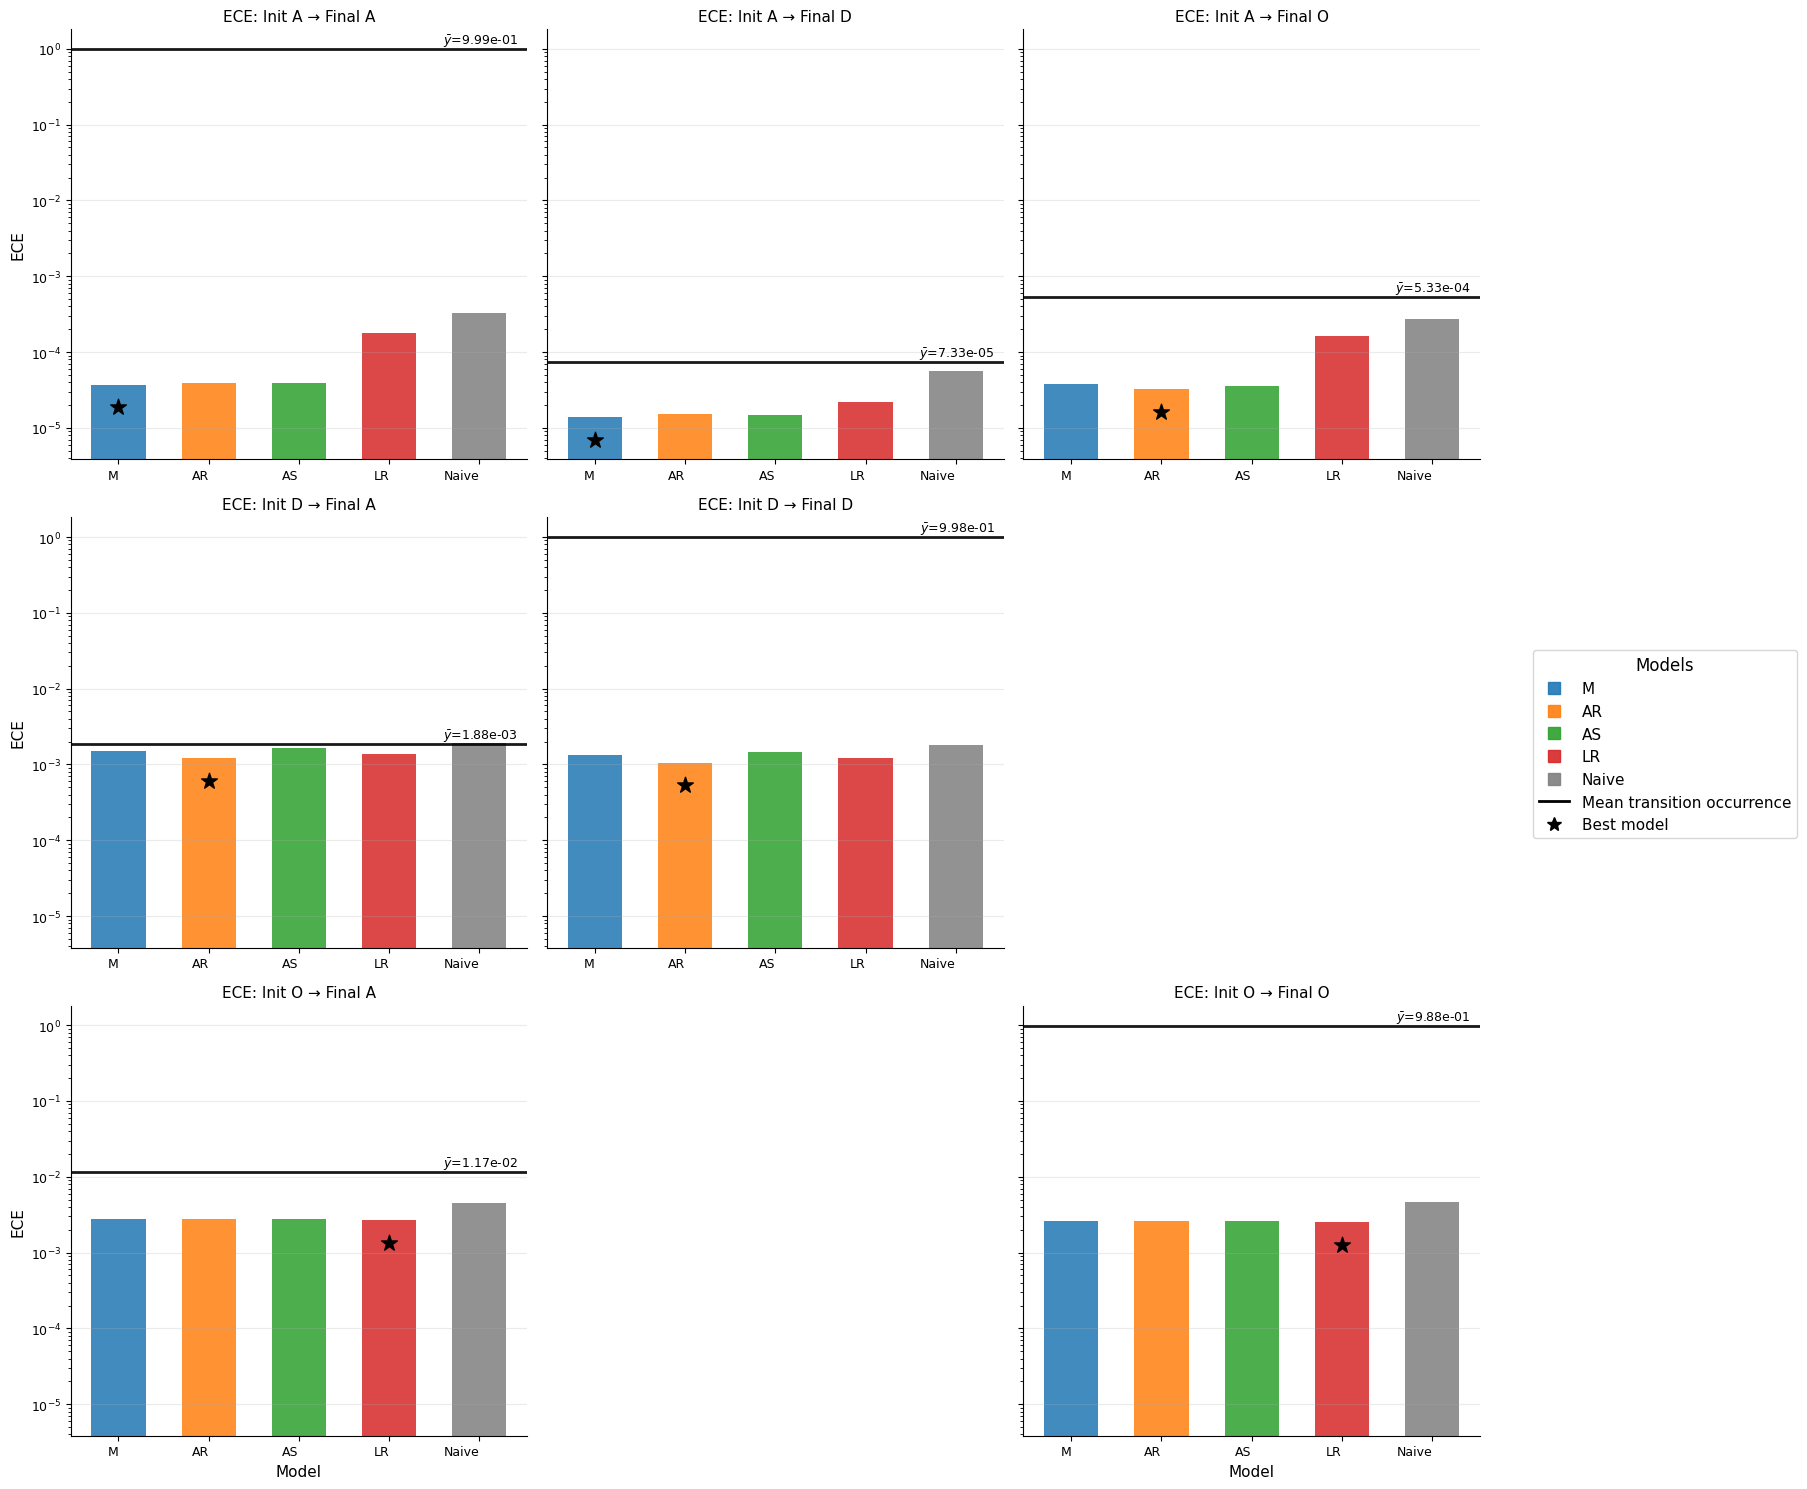

In [23]:
ece_results = plot_ece_matrix_with_prevalence_line(
    models_evaluated=models_evaluated,
    ece_equal_count_bins=ece_equal_count_bins,
    state_idx2str=state_idx2str,
    model_colors=model_colors,
    exclude_states=exclude_states,
    n_bins=20,
    figsize=(15, 15),
)